# Forecast: Coca Cola Earnings 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('coca_cola_earnings.csv')

## Data Exploration

In [3]:
df.head()

,anntime,value
0,1983/04/26,375
1,1983/07/25,492
2,1983/11/02,463
3,1984/02/14,379
4,1984/04/19,425


In [4]:
df['anntime'] = pd.to_datetime(df.anntime)

In [5]:
df.tail()

,anntime,value
102,2008-10-15,83
103,2009-02-12,64
104,2009-04-21,65
105,2009-07-21,92
106,2009-10-20,82


In [7]:
df.set_index('anntime',inplace=True)

In [8]:
df.head()

,value
anntime,
1983-04-26,375
1983-07-25,492
1983-11-02,463
1984-02-14,379
1984-04-19,425


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
value,107.0,205.383178,321.383585,1.0,37.0,57.0,250.0,1725.0


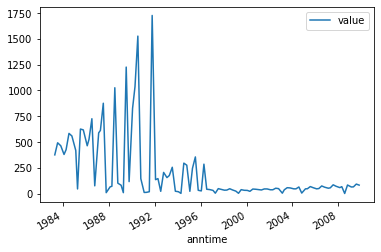

In [10]:
df.plot()

In [11]:
timeseries = df['value']

## Visualize Basic Forecast

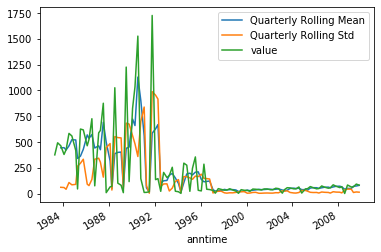

In [58]:
timeseries.rolling(3).mean().plot(label='Quarterly Rolling Mean')
timeseries.rolling(3).std().plot(label='Quarterly Rolling Std')
timeseries.plot()
plt.legend()

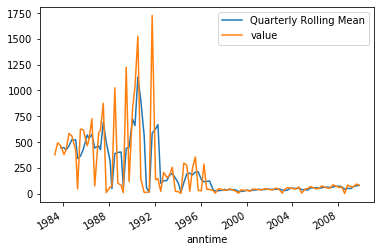

In [57]:
timeseries.rolling(3).mean().plot(label='Quarterly Rolling Mean')
timeseries.plot()
plt.legend()

## Decomposition

C:\Users\Katlego\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

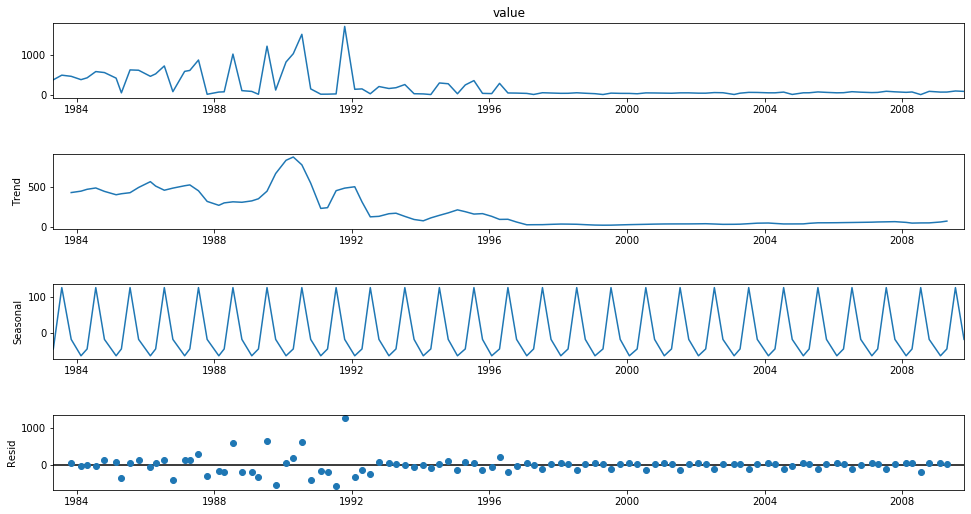

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['value'], freq=4)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

# Box Jenkins Methodology

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
result = adfuller(df['value'])

## Stationarity Test

In [19]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.736783048838734
p-value : 0.4122672803979332
#Lags Used : 6
Number of Observations Used : 100
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [20]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

## Differencing

In [21]:
df['Val_1st_diff'] = df['value'] - df['value'].shift(1)

In [23]:
adf_check(df['Val_1st_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.615734065491957
p-value : 2.1944468898912427e-11
#Lags Used : 5
Number of Observations Used : 100
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


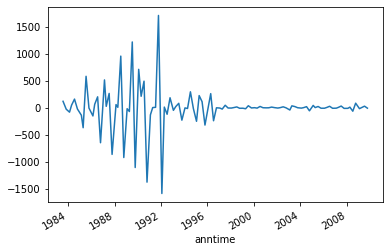

In [26]:
df['Val_1st_diff'].plot()

In [27]:
df['Val_2nd_diff'] = df['Val_1st_diff'] - df['Val_1st_diff'].shift(1)

In [29]:
adf_check(df['Val_2nd_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.479294831847005
p-value : 4.8198043337194807e-11
#Lags Used : 8
Number of Observations Used : 96
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


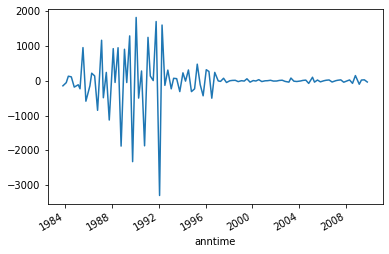

In [32]:
df['Val_2nd_diff'].plot()

In [33]:
df['Seas_1st_diff'] = df['value'] - df['value'].shift(4)

In [36]:
adf_check(df['Seas_1st_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.39464737569969
p-value : 3.475998251025439e-06
#Lags Used : 7
Number of Observations Used : 95
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [37]:
adf_check(df['Seas_1st_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.39464737569969
p-value : 3.475998251025439e-06
#Lags Used : 7
Number of Observations Used : 95
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


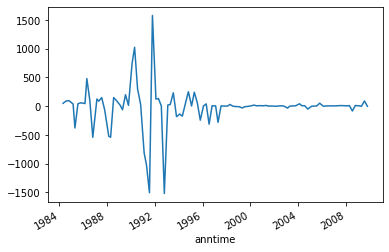

In [38]:
df['Seas_1st_diff'].plot()

## ACF and PACF

In [39]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

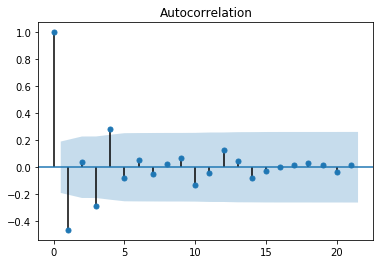

In [40]:
fig_first = plot_acf(df['Val_1st_diff'].dropna())

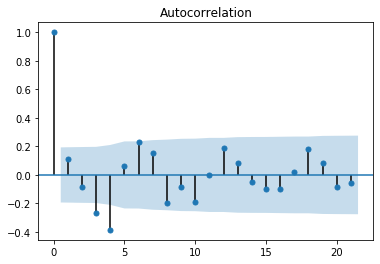

In [41]:
fig_seasonal_first = plot_acf(df['Seas_1st_diff'].dropna())

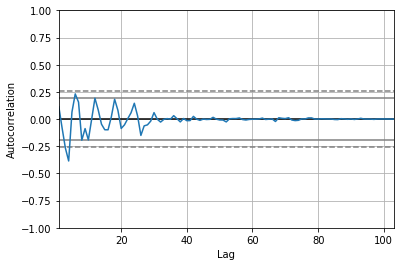

In [42]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Seas_1st_diff'].dropna())

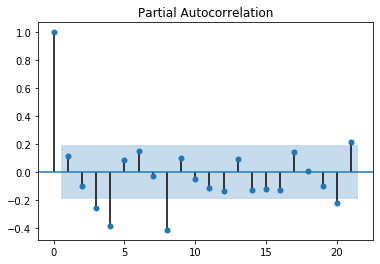

In [43]:
result = plot_pacf(df['Seas_1st_diff'].dropna())

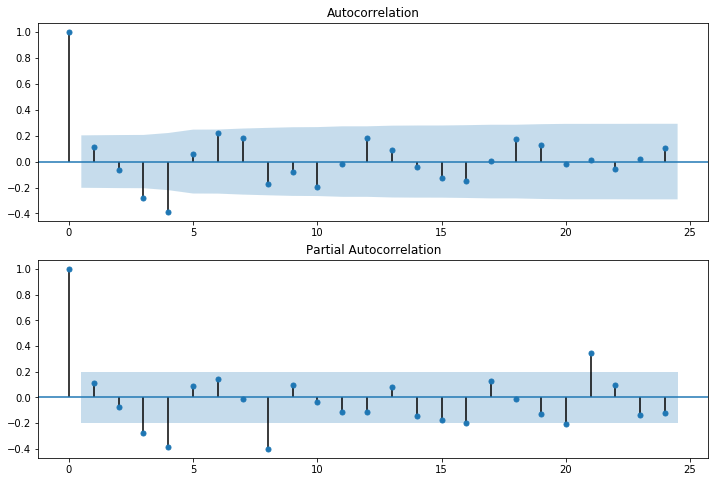

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seas_1st_diff'].iloc[13:], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seas_1st_diff'].iloc[13:], lags=24, ax=ax2)

# Seasonal Model

In [52]:
model = sm.tsa.statespace.SARIMAX(df['value'],order=(0,1,0), seasonal_order=(1,1,0,4))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  107
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                -765.851
Date:                           Mon, 23 Mar 2020   AIC                           1535.703
Time:                                   23:35:09   BIC                           1540.953
Sample:                                        0   HQIC                          1537.829
                                           - 107                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4       -0.3104      0.059     -5.247      0.000      -0.426      -0.194
sigma2          2e+05   8494.945     23.539

C:\Users\Katlego\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Katlego\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


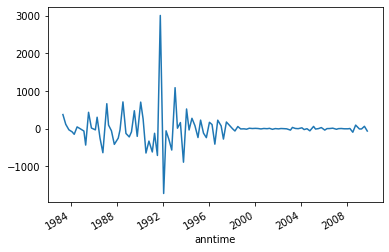

In [53]:
results.resid.plot()

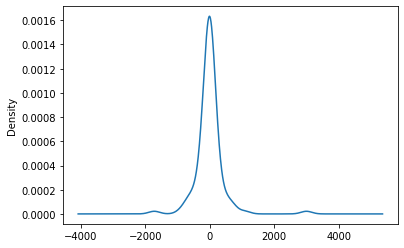

In [54]:
results.resid.plot(kind='kde')

C:\Users\Katlego\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Katlego\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


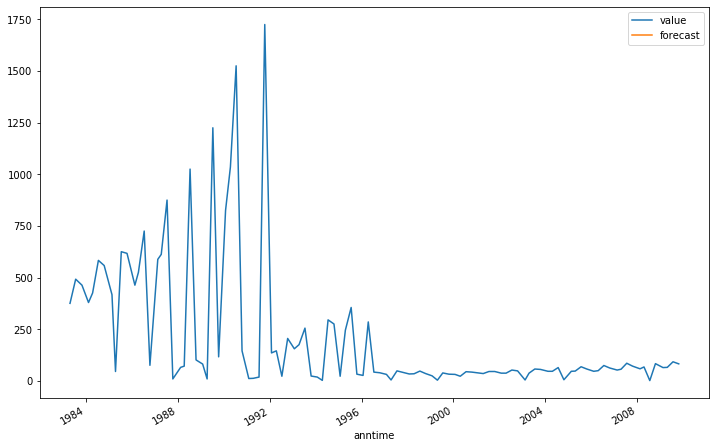

In [56]:
df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)  
df[['value','forecast']].plot(figsize=(12,8))